# Common imports

In [1]:
#%matplotlib inline
%matplotlib notebook
import os
import sys
import glob
import re
import numpy as np
# np.set_printoptions(threshold=np.nan)
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import random
import timeit

# Provided functions
### Image loading and saving

In [2]:
def LoadFaceImages(pathname, subject_name, num_images):
    """
    Load the set of face images.  
    The routine returns
        ambimage: image illuminated under the ambient lighting
        imarray: a 3-D array of images, h x w x Nimages
        lightdirs: Nimages x 3 array of light source directions
    """

    def load_image(fname):
        return np.asarray(Image.open(fname))

    def fname_to_ang(fname):
        yale_name = os.path.basename(fname)
        return int(yale_name[12:16]), int(yale_name[17:20])

    def sph2cart(az, el, r):
        rcos_theta = r * np.cos(el)
        x = rcos_theta * np.cos(az)
        y = rcos_theta * np.sin(az)
        z = r * np.sin(el)
        return x, y, z

    ambimage = load_image(
        os.path.join(pathname, subject_name + '_P00_Ambient.pgm'))
    im_list = glob.glob(os.path.join(pathname, subject_name + '_P00A*.pgm'))
    if num_images <= len(im_list):
        im_sub_list = np.random.choice(im_list, num_images, replace=False)
    else:
        print(
            'Total available images is less than specified.\nProceeding with %d images.\n'
            % len(im_list))
        im_sub_list = im_list
    im_sub_list.sort()
    imarray = np.stack([load_image(fname) for fname in im_sub_list], axis=-1)
    Ang = np.array([fname_to_ang(fname) for fname in im_sub_list])

    x, y, z = sph2cart(Ang[:, 0] / 180.0 * np.pi, Ang[:, 1] / 180.0 * np.pi, 1)
    lightdirs = np.stack([y, z, x], axis=-1)
    return ambimage, imarray, lightdirs

In [3]:
def save_outputs(subject_name, albedo_image, surface_normals):
    im = Image.fromarray((albedo_image*255).astype(np.uint8))
    im.save("%s_albedo.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,0]*128+128).astype(np.uint8))
    im.save("%s_normals_x.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,1]*128+128).astype(np.uint8))
    im.save("%s_normals_y.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,2]*128+128).astype(np.uint8))
    im.save("%s_normals_z.jpg" % subject_name)

### Plot the height map

In [4]:
def set_aspect_equal_3d(ax):
    """https://stackoverflow.com/questions/13685386"""
    """Fix equal aspect bug for 3D plots."""
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    from numpy import mean
    xmean = mean(xlim)
    ymean = mean(ylim)
    zmean = mean(zlim)
    plot_radius = max([
        abs(lim - mean_)
        for lims, mean_ in ((xlim, xmean), (ylim, ymean), (zlim, zmean))
        for lim in lims
    ])
    ax.set_xlim3d([xmean - plot_radius, xmean + plot_radius])
    ax.set_ylim3d([ymean - plot_radius, ymean + plot_radius])
    ax.set_zlim3d([zmean - plot_radius, zmean + plot_radius])


def display_output(albedo_image, height_map,title):
#     fig = plt.figure()
#     plt.imshow(albedo_image, cmap='gray')
#     plt.axis('off')
    
    fig = plt.figure(figsize=(7, 7))
    ax = fig.gca(projection='3d')
    ax.view_init(20, 20)
    X = np.arange(albedo_image.shape[0])
    Y = np.arange(albedo_image.shape[1])
    
    X, Y = np.meshgrid(Y, X)
    H = np.flipud(np.fliplr(height_map))
    A = np.flipud(np.fliplr(albedo_image))
    A = np.stack([A, A, A], axis=-1)
    ax.xaxis.set_ticks([])
    ax.xaxis.set_label_text('Z')
    ax.yaxis.set_ticks([])
    ax.yaxis.set_label_text('X')
    ax.zaxis.set_ticks([])
    ax.yaxis.set_label_text('Y')
    surf = ax.plot_surface(
        H, X, Y, cmap='gray', facecolors=A, linewidth=0, antialiased=False)
    plt.title(title)
    set_aspect_equal_3d(ax)

### Plot the surface norms. 

In [5]:
def plot_surface_normals(surface_normals):
    """
    surface_normals: h x w x 3 matrix.
    """
    fig = plt.figure()
    ax = plt.subplot(1, 3, 1)
    ax.axis('off')
    ax.set_title('X')
    im = ax.imshow(surface_normals[:,:,0],cmap = 'jet')
    ax = plt.subplot(1, 3, 2)
    ax.axis('off')
    ax.set_title('Y')
    im = ax.imshow(surface_normals[:,:,1],cmap = 'jet')
    ax = plt.subplot(1, 3, 3)
    ax.axis('off')
    ax.set_title('Z')
    im = ax.imshow(surface_normals[:,:,2],cmap = 'jet')

# Your implementation

In [6]:
def preprocess(ambimage, imarray):
    """
    preprocess the data: 
        1. subtract ambient_image from each image in imarray.
        2. make sure no pixel is less than zero.
        3. rescale values in imarray to be between 0 and 1.
    Inputs:
        ambimage: h x w
        imarray: h x w x Nimages    
    Outputs:
        processed_imarray: h x w x Nimages
    """
   
    im_shape = imarray.shape  
    processed_imarray = np.zeros(im_shape)
    
    #Subtract all the images in imarray by ambimage
    processed_imarray = imarray - ambimage[:,:,np.newaxis]

    #Set all the negative numbers in processed array to zero
    processed_imarray[processed_imarray < 0] = 0
    
    #Rescale
    processed_imarray = np.divide(processed_imarray,255.0)
  
    return processed_imarray

In [7]:
def photometric_stereo(imarray, light_dirs):
    """
    Inputs:
        imarray:  h x w x Nimages
        light_dirs: Nimages x 3
   Outputs:
        albedo_image: h x w
        surface_norms: h x w x 3  
    """
    
    im = imarray.shape
    a = np.reshape(imarray,im[0]*im[1]*im[2],'F') 

    #convert into rows = nums of pixels and 64 columns 
    b = np.reshape(a,(im[0]*im[1],im[2]),'F')
    
    c = b.T
    
    e= np.zeros((3,im[0]*im[1]))
    g = np.linalg.lstsq(light_dirs,c,rcond=None)[0]
    g= g.T
    
    
    #transform back to a 3-d matrix h x w x 3 
    g_3d = np.reshape(g,(im[0],im[1],3),'F')

    normal_x = np.zeros((im[0],im[1]))
    normal_y = np.zeros((im[0],im[1]))
    normal_z = np.zeros((im[0],im[1]))

    surface_normals = np.zeros((im[0],im[1],3))

    fx = np.divide(g_3d[:,:,0],g_3d[:,:,2])     
    fy = np.divide(g_3d[:,:,1],g_3d[:,:,2])
    normal_z = 1/np.sqrt(fx**2+fy**2+1)

    surface_normals[:,:,0] = np.multiply(normal_z,fx)
    surface_normals[:,:,1] = np.multiply(normal_z,fy)
    surface_normals[:,:,2] = normal_z

    albedo_image = np.zeros((im[0],im[1]))
    albedo_image = np.sqrt(g_3d[:,:,0]**2+g_3d[:,:,1]**2+g_3d[:,:,2]**2)

    
    return albedo_image, surface_normals

In [8]:
def get_surface(surface_normals, integration_method):
    """
    Inputs:
        surface_normals:h x w x 3
        integration_method: string in ['average', 'column', 'row', 'random']
    Outputs:
        height_map: h x w
        
    """
 
    sh= surface_normals.shape
    fx = np.zeros((sh[0],sh[1]))
    fy = np.zeros((sh[0],sh[1]))
    fx = np.multiply(surface_normals[:,:,0],surface_normals[:,:,2])
    fy = np.multiply(surface_normals[:,:,1],surface_normals[:,:,2])
    
    
    height_map = np.zeros((sh[0],sh[1]))
    surf_sum = surface_normals[:,:,0]+surface_normals[:,:,0] + surface_normals[:,:,0]
    
    
    if integration_method == 'average':
            for i in range (sh[0]):
                for j in range (sh[1]):
                    if i==0 and j ==0:
                        height_map[i,j] = surf_sum[i,j]     
                    else: 
                        height_map[i,j] = (sum(fx[i,0:j+1]) + sum(fy[0:i,0])+sum(fy[0:i+1,j]) + sum(fx[0,0:j]))/2
            
        
    elif integration_method == 'column':
        for i in range (sh[0]):
                for j in range (sh[1]):
                    if i==0 and j ==0:
                        height_map[i,j] = surf_sum[i,j]     
                    else: 
                        height_map[i,j] = sum(fx[i,0:j+1]) + sum(fy[0:i,0])
                        
        

    elif integration_method == 'row':
        for i in range (sh[0]):
                for j in range (sh[1]):
                    if i==0 and j ==0:
                        height_map[i,j] = surf_sum[i,j]     
                    else: 
                        height_map[i,j] = sum(fy[0:i+1,j]) + sum(fx[0,0:j])
                        
                        
        
    elif integration_method == 'random': 
        for i in range(sh[0]):
            for j in range(sh[1]):
                if i == 0 and j == 0:
                    height_map[i,j] = fx[i,j]        
                elif i == 0 and j != 0:
                    height_map[i,j] = sum(fx[0,0:j+1])       
                elif i != 0 and j == 0:
                    height_map[i,j] = sum(fy[0:i+1,0])       
                else:
                    go = True
                    total = 0
                    x = 0
                    y = 0
                    count =0 
                    while go == True:                         
                            f_xy = random.randint(0,1)
                            if f_xy == 0 and j-y > 0:
                                step = random.randint(1,j-y)
                                total = total + sum(fx[x,y+1:y+step+1])
                                y = y +step

                            elif f_xy == 1 and i-x > 0:
                                step = random.randint(1,i-x)
                                total = total + sum(fy[x+1:x+step+1,y])
                                x = x + step
                            else:
                                count 

                            if x==i and y==j:         
                                height_map[i,j] = total+ fx[0,0]
                                go = False
    else:
        i = 0

    return height_map

# Main function

In [9]:
root_path = '../croppedyale/'
subject_name = 'yaleB01'
save_flag = True

full_path = '%s%s' % (root_path, subject_name)
ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name, 64)

processed_imarray = preprocess(ambient_image, imarray)

albedo_image, surface_normals = photometric_stereo(processed_imarray,light_dirs)

if save_flag:
    save_outputs(subject_name, albedo_image, surface_normals)


In [10]:
##getting height maps of different method 

sh= surface_normals.shape
height_map1 = np.zeros((sh[0],sh[1]))
height_map2 = np.zeros((sh[0],sh[1]))
height_map3 = np.zeros((sh[0],sh[1]))
height_map4 = np.zeros((sh[0],sh[1]))
turns = 30
maps = np.zeros((sh[0],sh[1],turns))

#column then row method
start = timeit.default_timer()
height_map1 =  get_surface(surface_normals, 'column')
    
stop = timeit.default_timer()
print('Time of column then row method: ', stop - start)  
    
#row then column method
start = timeit.default_timer()
height_map2 = get_surface(surface_normals, 'row')
    
stop = timeit.default_timer()
print('Time of row then column method: ', stop - start)  

#average of the column/row and row/column method
start = timeit.default_timer()
height_map3 = get_surface(surface_normals, 'average')
stop = timeit.default_timer()
print('Time of average col/row and row/col method: ', stop - start)  


#average of multiple random path. Currently I am average 30 paths 
start = timeit.default_timer()

for i in range(turns):
    maps[:,:,i]   = get_surface(surface_normals, 'random')
    height_map4 =  height_map4 + maps[:,:,i]
    
height_map4 = height_map4/turns

stop = timeit.default_timer()
print('Time of average 30 random paths method: ', stop - start)  


Time of column then row method:  1.204590323
Time of row then column method:  1.1093772350000002
Time of average col/row and row/col method:  2.2798236999999997
Time of average 30 random paths method:  79.207831772


<IPython.core.display.Javascript object>


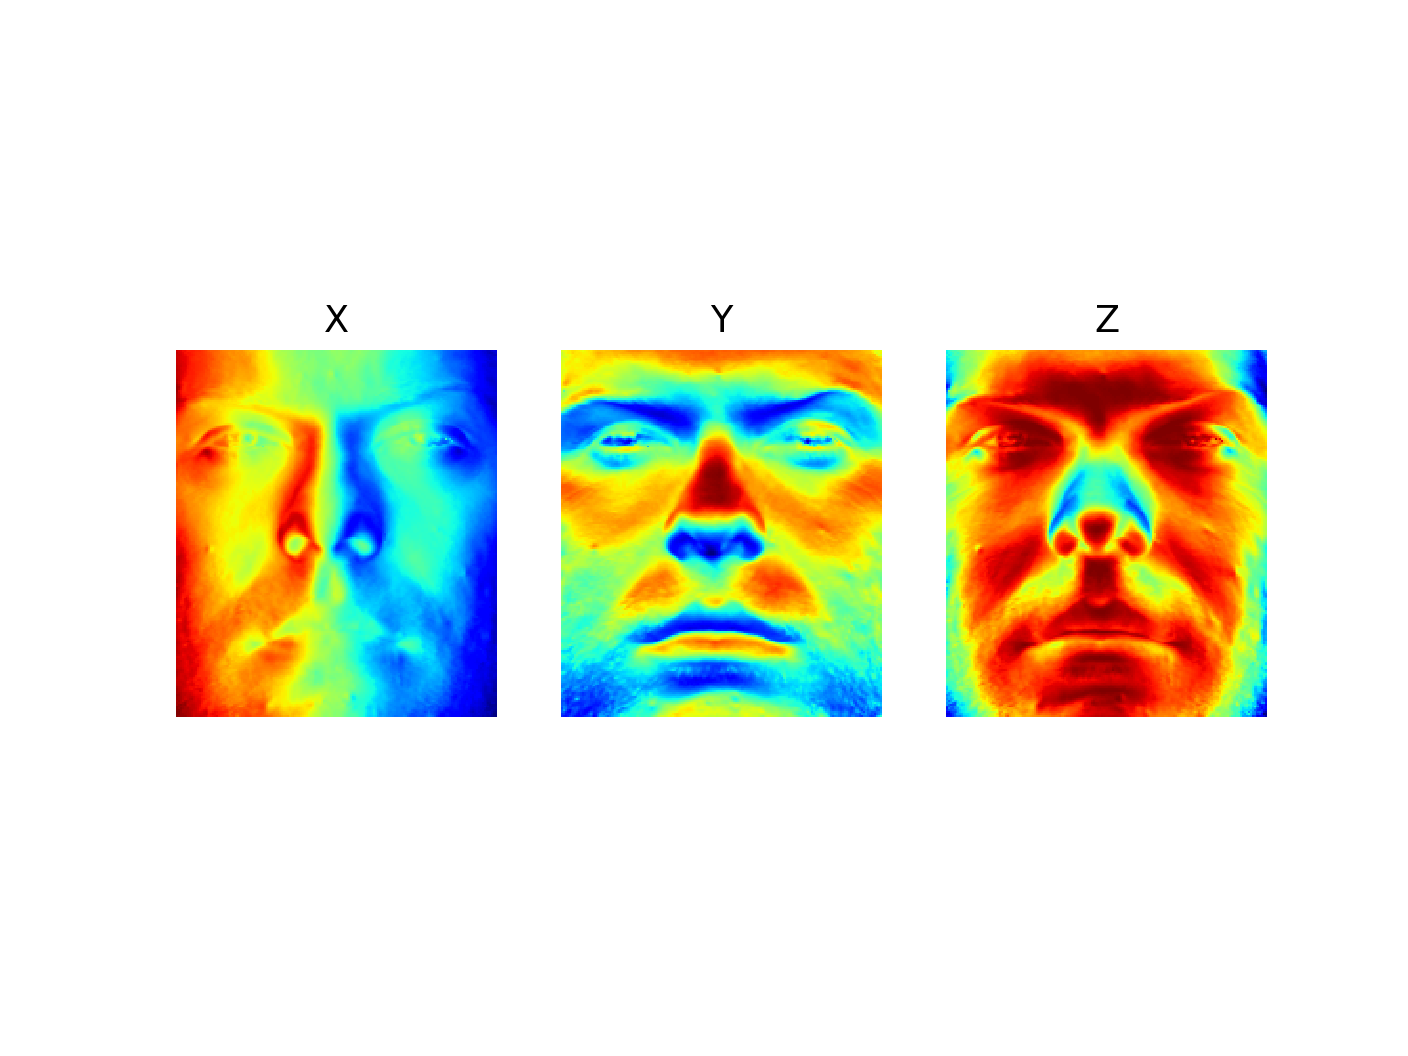

In [11]:
#Surface Normals
plot_surface_normals(surface_normals)

<IPython.core.display.Javascript object>


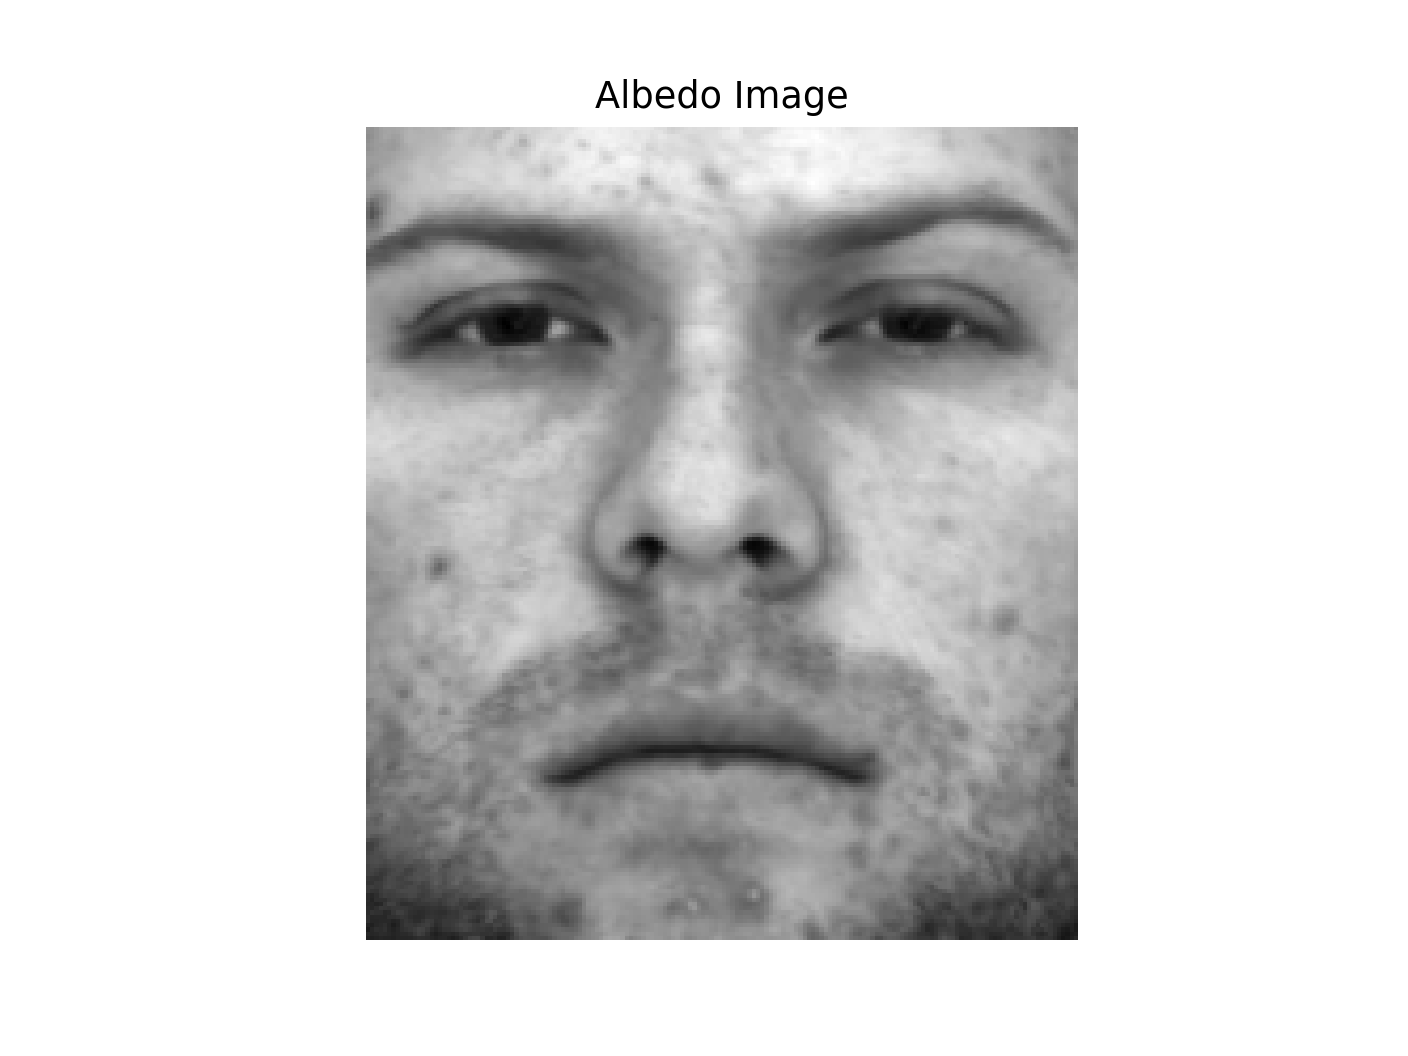

(-0.5, 167.5, 191.5, -0.5)

In [12]:
#I separate the albedo image and the different methods

fig = plt.figure()
plt.title('Albedo Image')
plt.imshow(albedo_image, cmap='gray')
plt.axis('off')

<IPython.core.display.Javascript object>


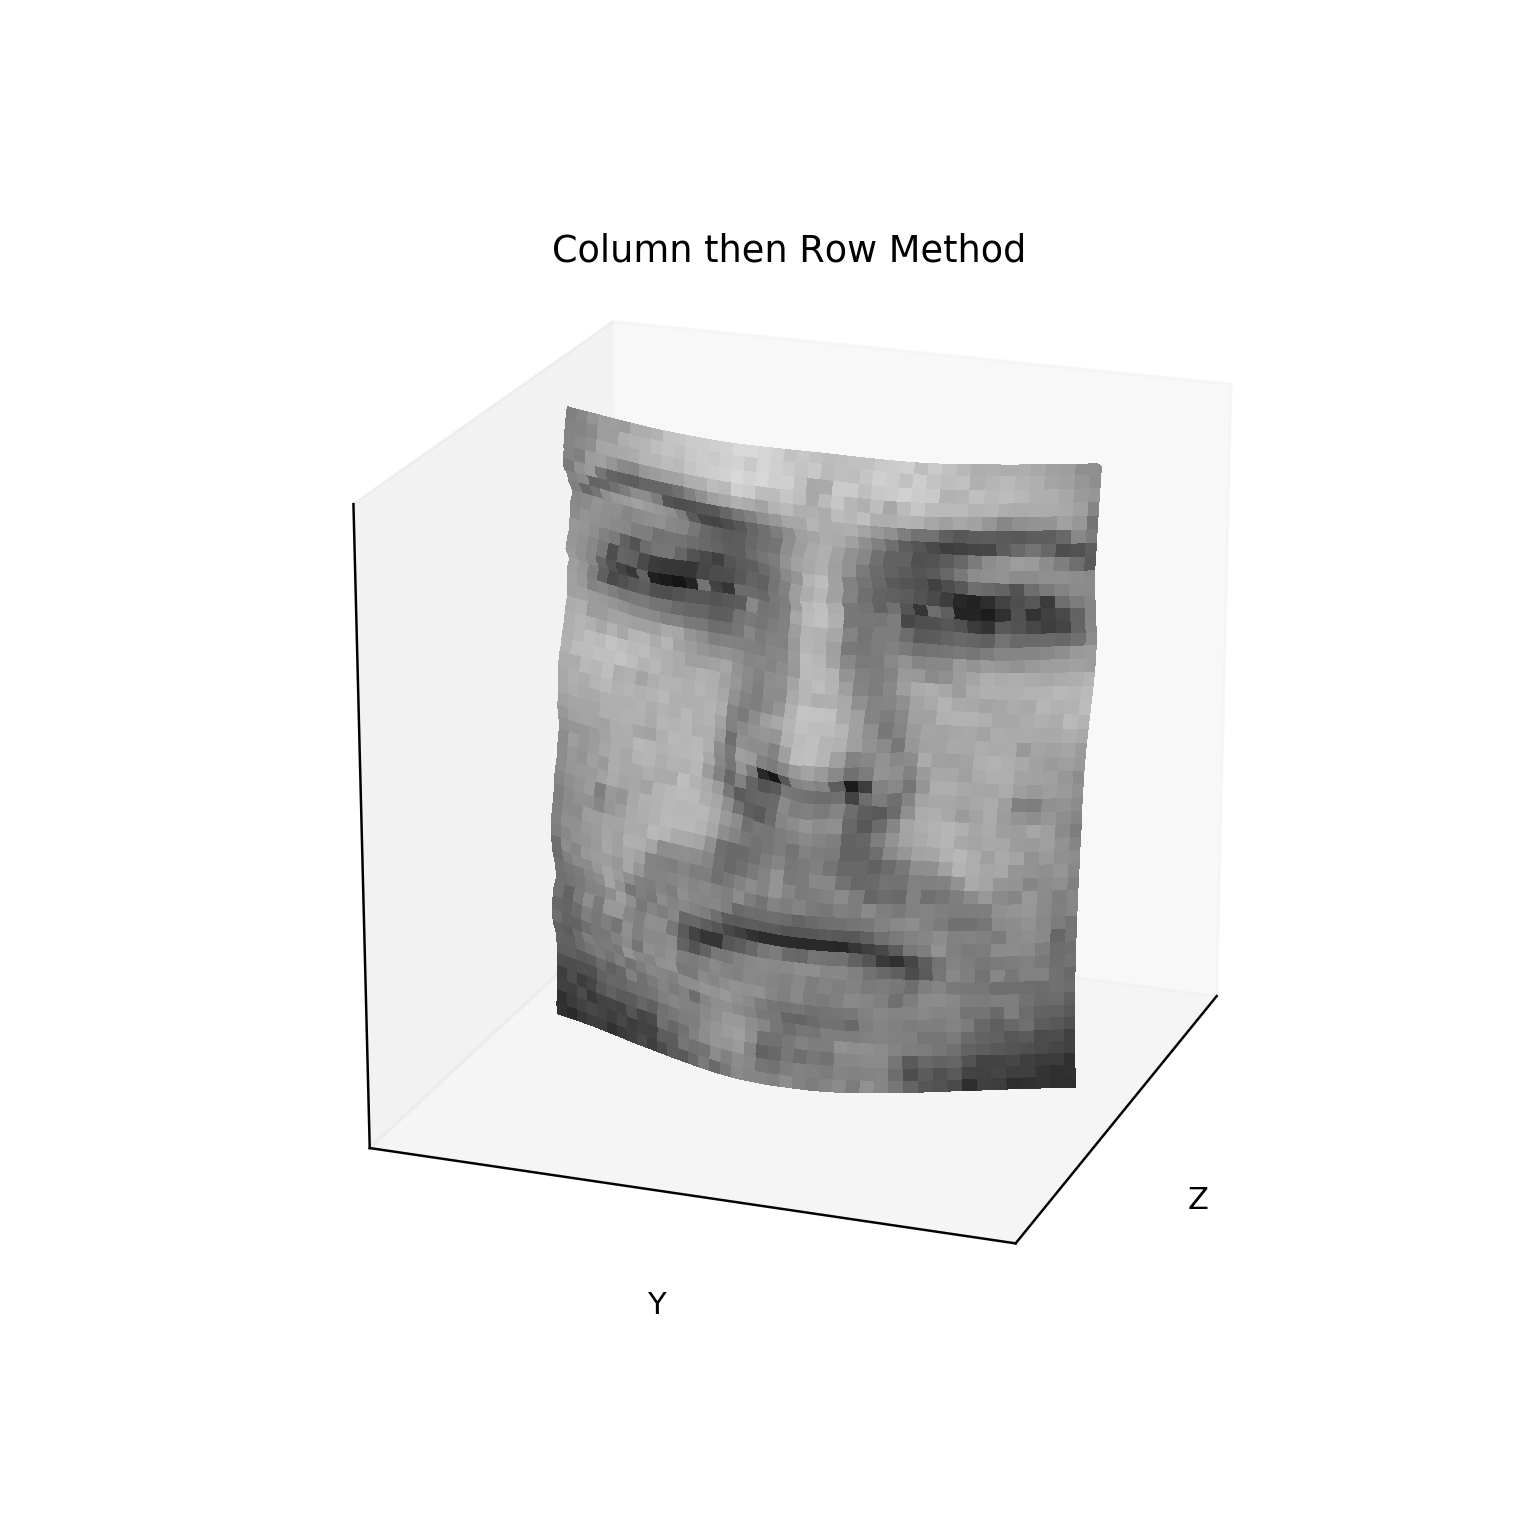

<IPython.core.display.Javascript object>


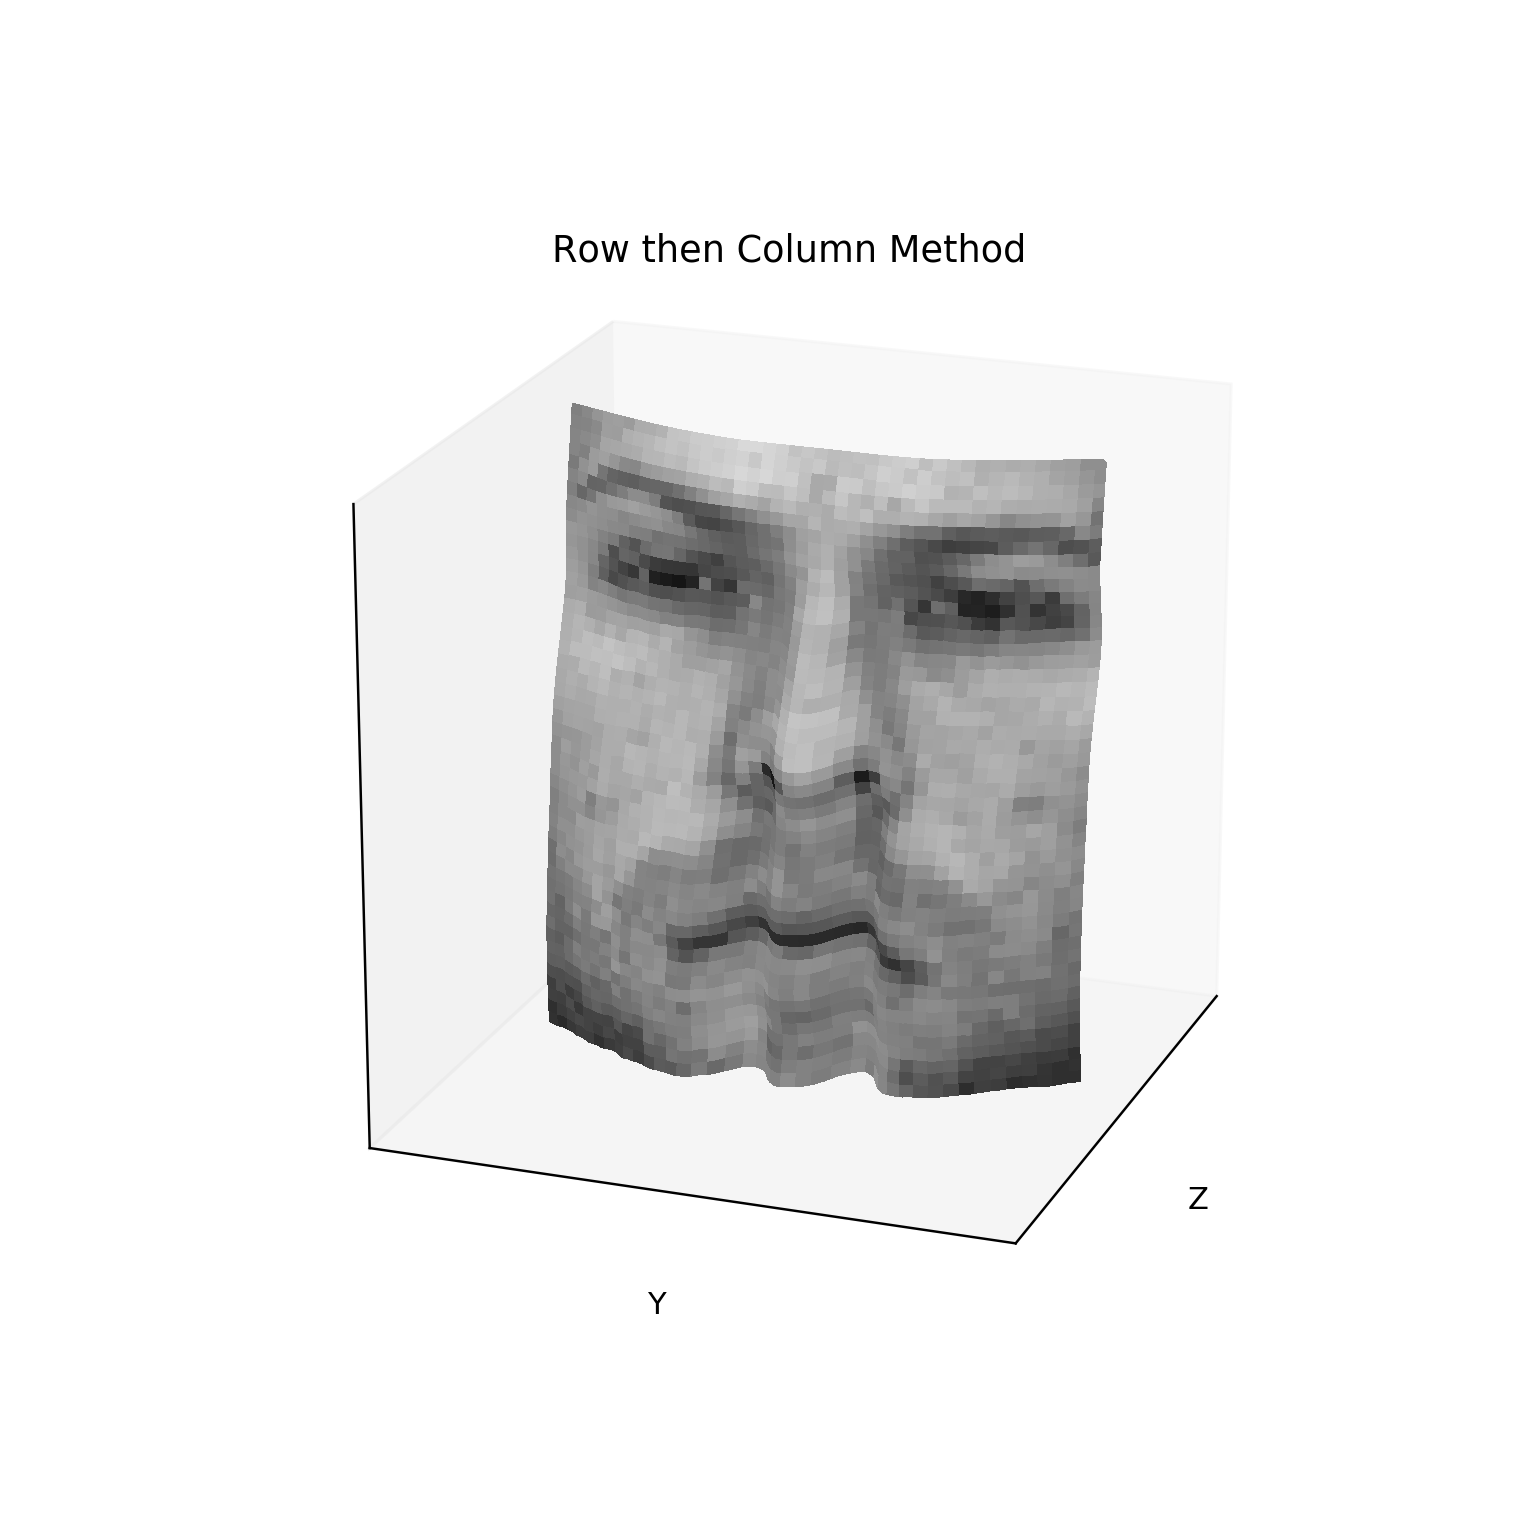

<IPython.core.display.Javascript object>


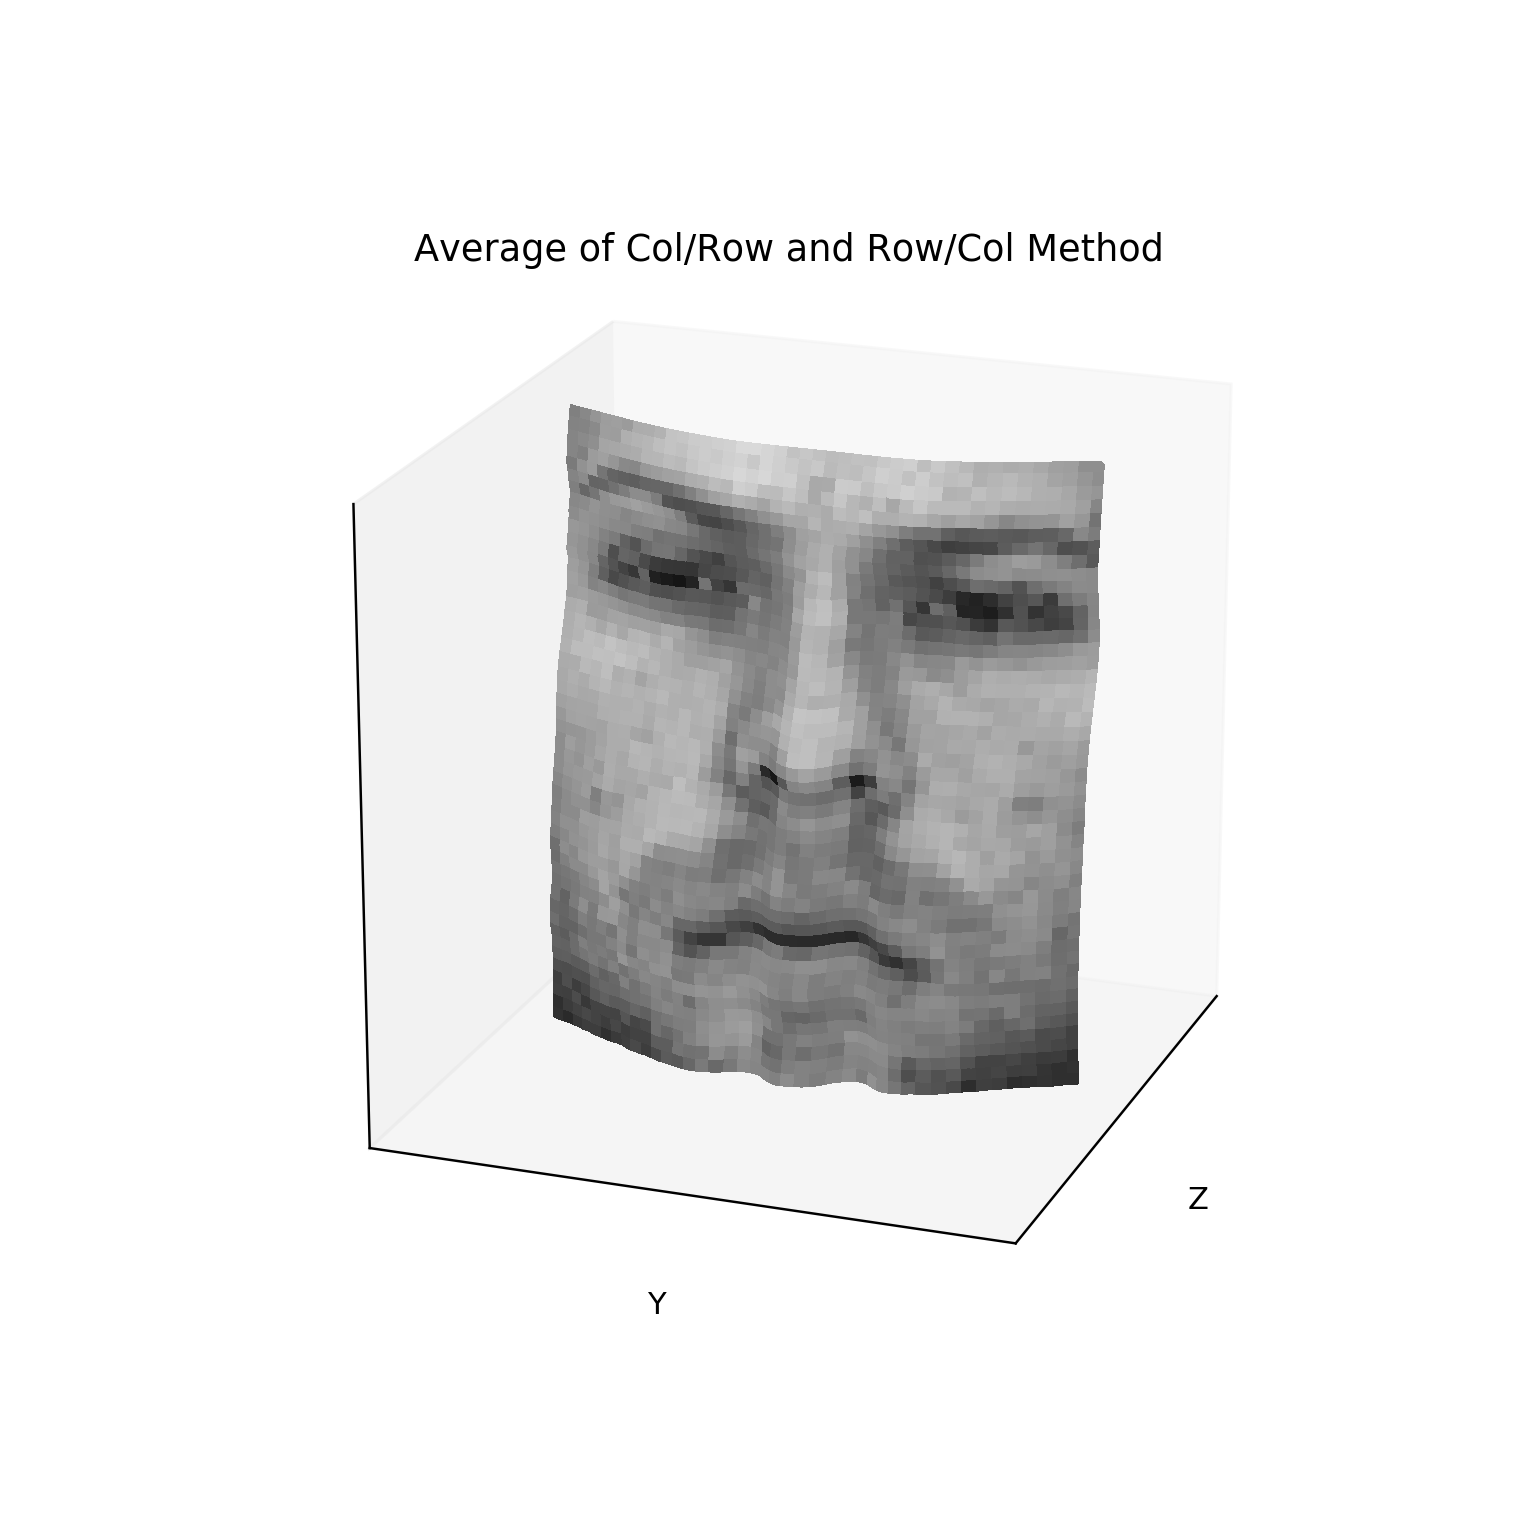

<IPython.core.display.Javascript object>


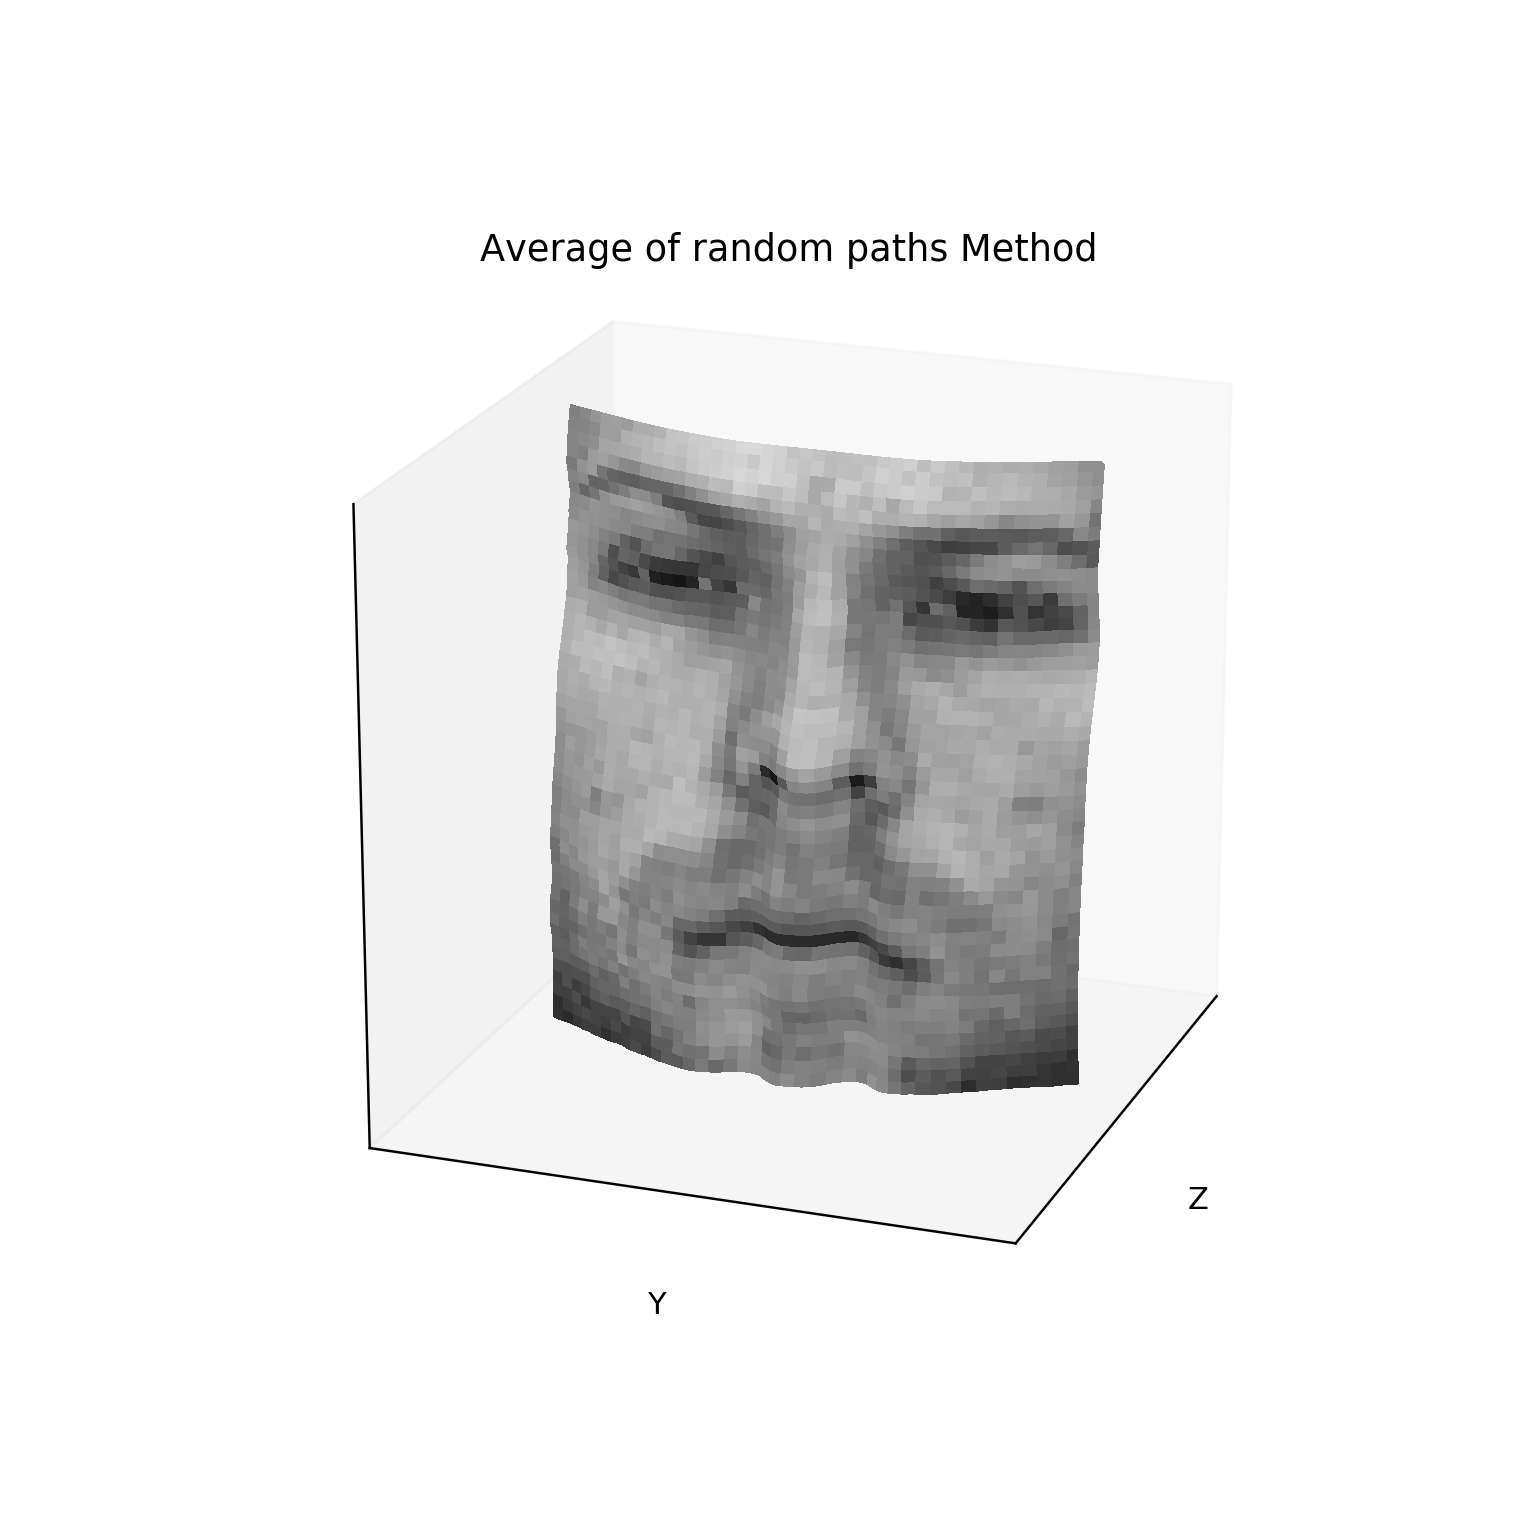

In [13]:
#Display different Methods, I change the display_output function is it only display height maps
display_output(albedo_image, height_map1, 'Column then Row Method')

display_output(albedo_image, height_map2,'Row then Column Method')

display_output(albedo_image, height_map3,'Average of Col/Row and Row/Col Method')

display_output(albedo_image, height_map3,'Average of random paths Method')